In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import itertools

import matplotlib.pyplot as plt
import seaborn as sb


In [2]:
results = pd.read_csv("metrics_new.csv")

dataf = results[results["algo"] == "datafly"]
mondr = results[results["algo"] == "mondrian"]

In [3]:
results

,algo,no,dm,cm,entropy,acc,discern,ilm,precision
0,datafly,1,0.466667,0.555379,0.706496,0.351852,0.191784,0.155632,0.774183
1,mondrian,1,0.800000,0.446211,0.447258,0.486772,0.029170,0.173992,0.798010
2,datafly,2,0.466667,0.531532,0.681409,0.320106,0.272468,0.195183,0.799293
3,mondrian,2,0.833333,0.475888,0.493873,0.428571,0.049105,0.185833,0.779291
4,datafly,3,0.400000,0.552729,0.727920,0.436508,0.196958,0.200000,0.780754
...,...,...,...,...,...,...,...,...,...
395,mondrian,198,0.833333,0.420774,0.485048,0.383598,0.064194,0.174704,0.781311
396,datafly,199,0.466667,0.563328,0.720435,0.359788,0.124594,0.169670,0.777160
397,mondrian,199,0.766667,0.438262,0.404751,0.343915,0.029238,0.173032,0.786204
398,datafly,200,0.400000,0.552729,0.759855,0.320106,0.248152,0.219626,0.794877


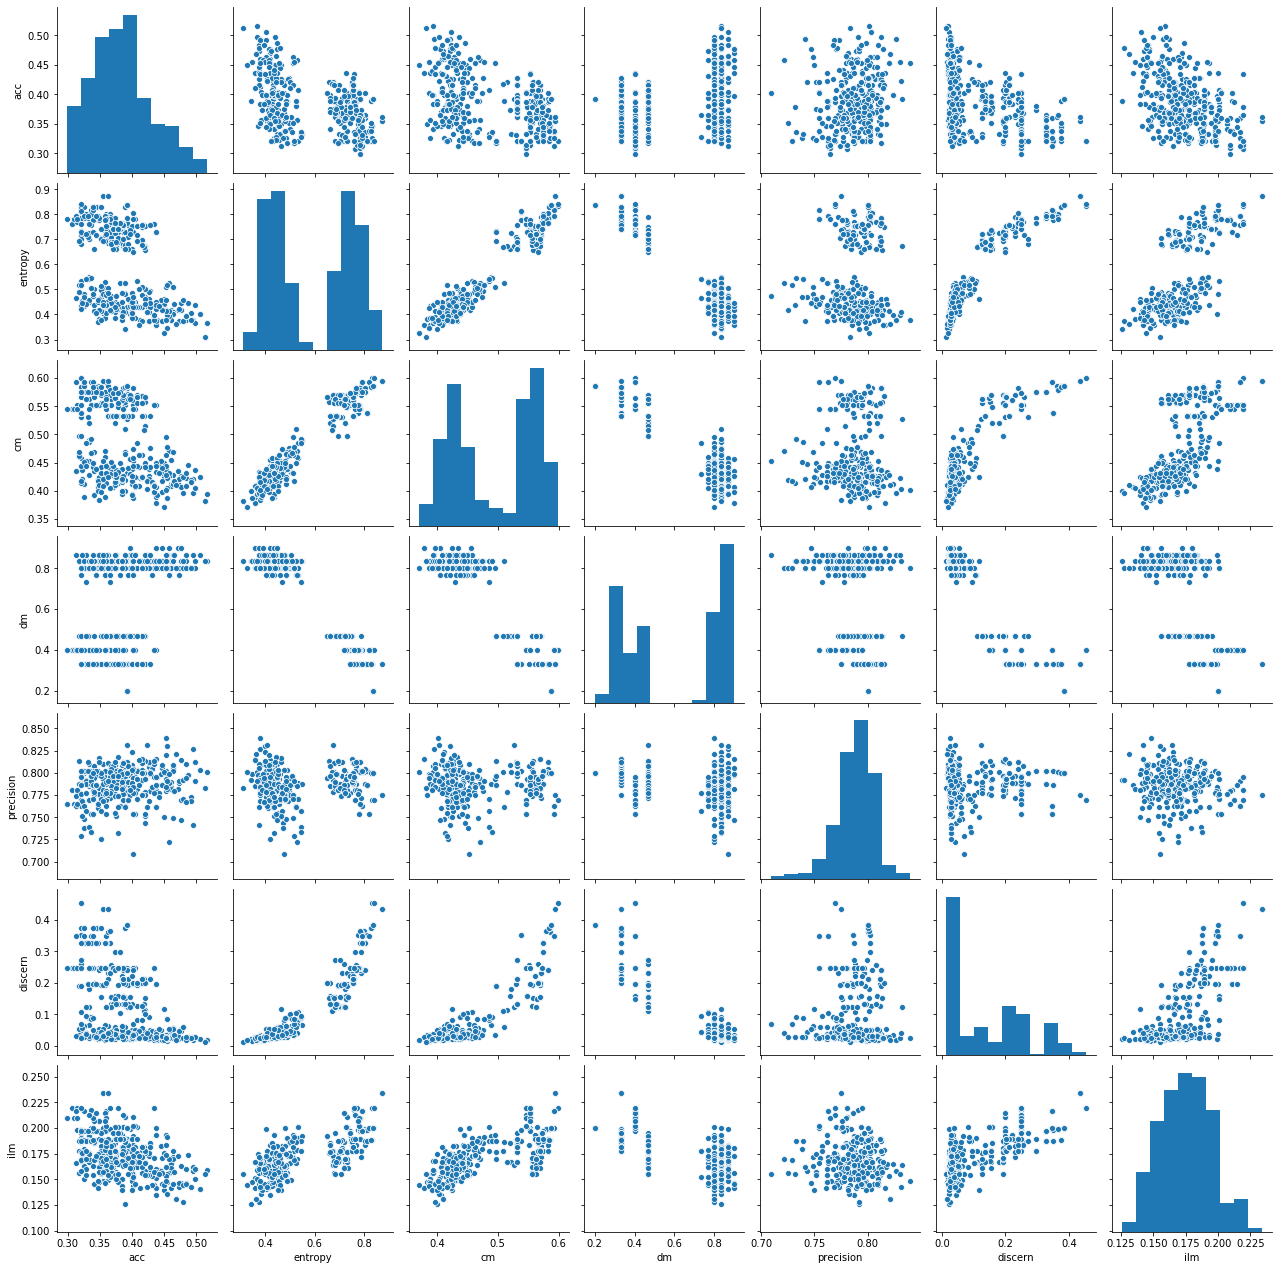

In [4]:
sb.pairplot(results[["acc", "entropy", "cm", "dm", "precision", "discern", "ilm"]])

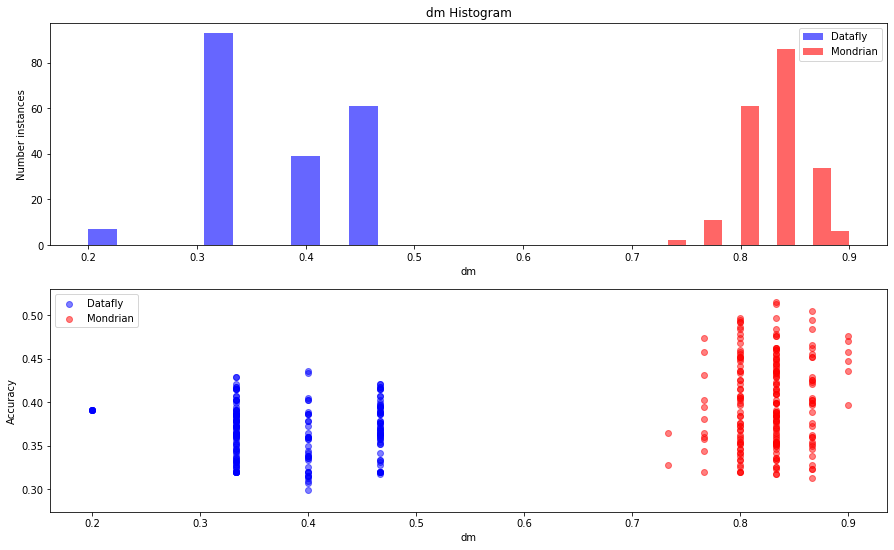

In [5]:
def plot_metric(metric):    
    fig, (ax1, ax2)= plt.subplots(2,1, figsize=(15,9))
    dataflys = results[results["algo"] == "datafly"]
    mondrians = results[results["algo"] == "mondrian"]
    
    ax1.hist(dataflys[metric], label="Datafly", color="b", alpha=.6)
    ax1.hist(mondrians[metric], label="Mondrian", color="r", alpha=.6)
    ax1.set_xlabel(metric)
    ax1.set_ylabel("Number instances")
    ax1.legend()
    ax1.set_title(f"{metric} Histogram")
    
    ax2.scatter(dataflys[metric], dataflys["acc"], c="b", alpha=0.5, label="Datafly")
    ax2.scatter(mondrians[metric], mondrians["acc"], c="r", alpha=0.5, label="Mondrian")
    ax2.set_xlabel(metric)
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    
plot_metric("dm")

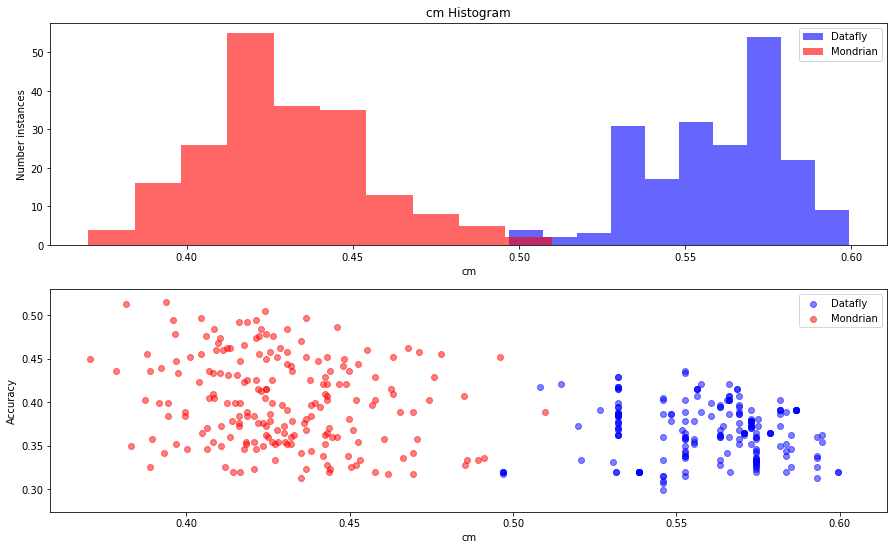

In [6]:
plot_metric("cm")

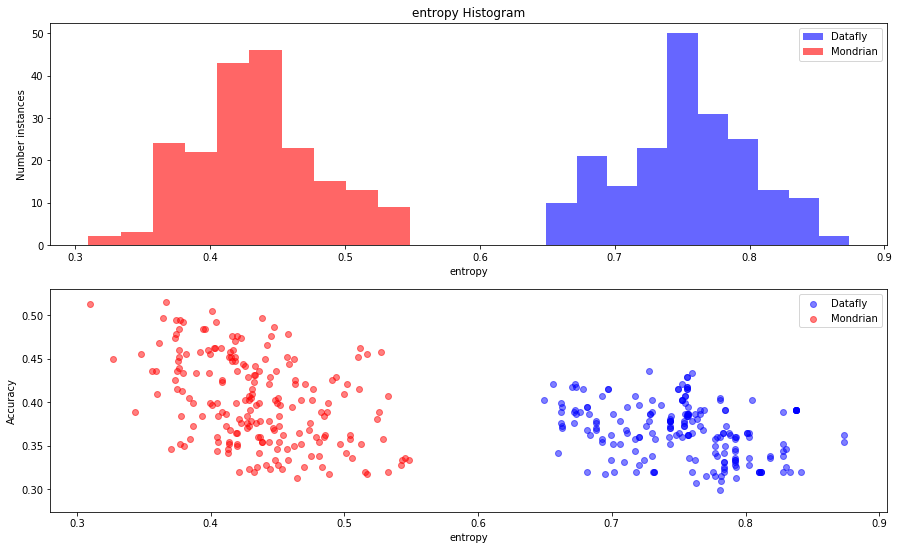

In [7]:
plot_metric("entropy")

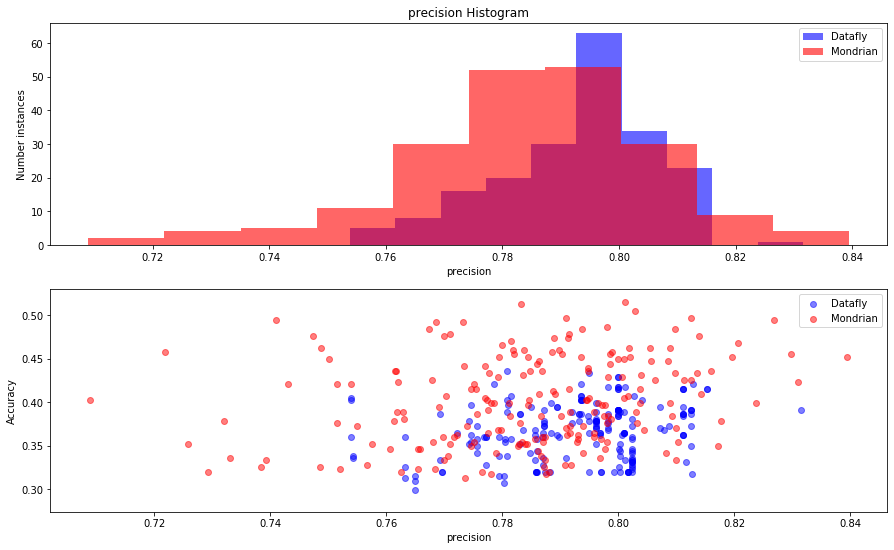

In [8]:
plot_metric("precision")

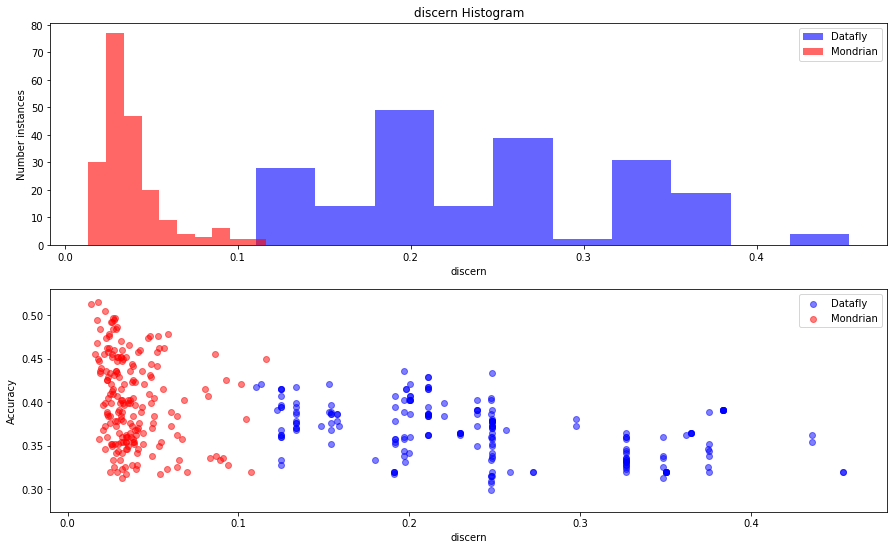

In [9]:
plot_metric("discern")

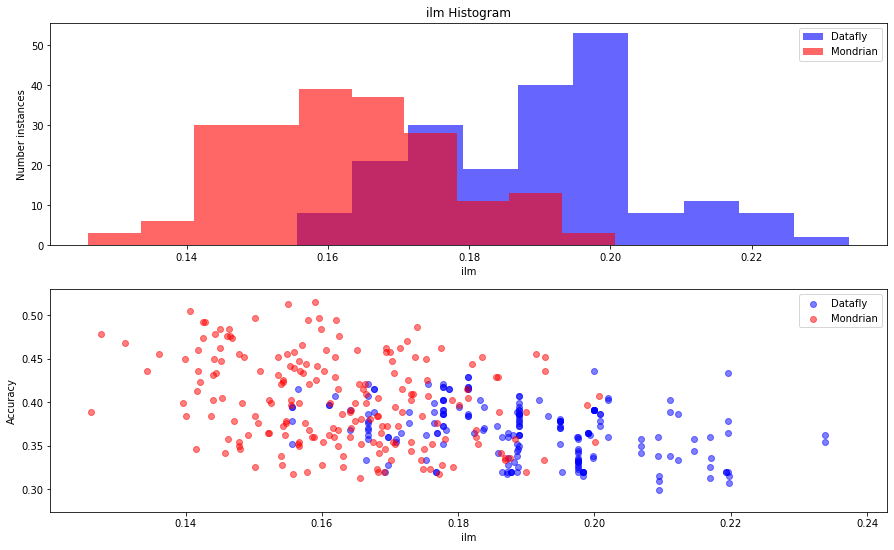

In [10]:
plot_metric("ilm")

# Predicting Power

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def regress(regressor, algo_data):

    X = algo_data[regressor]
    y = algo_data["acc"]

    reg = LinearRegression()
    reg.fit(X, y)

    score = reg.score(X,y)
    return reg, score

def mse(reg, attributes):
    attrs = np.array(results[attributes])
    attrs = attrs.reshape(-1,1) if len(attrs) == 1 else attrs
    y_pred = reg.predict(attrs)
    y_true = results["acc"]
    mse = mean_squared_error(y_true, y_pred)
    return mse

mses = []

In [12]:
def fit_and_graph(regressor, algo_data):
    print(f"Regression on {algo_data['algo'].iloc[0]}")
    reg, score = regress([regressor], algo_data)
    coeff = reg.coef_
    intercept = reg.intercept_
    
    err = mse(reg, [regressor])
    
    print(f"p-value: {scipy.stats.pearsonr(algo_data[regressor],algo_data['acc'])[1]}")
    print(f"R2 Score: {score}")
    print(f"MSE: {err}")
    print(f"Coeffs: {coeff}")
    print(f"Intercept: {intercept}")
    
    x = np.linspace(0,1,100)
    l = coeff*x + intercept
    
    algo_data.plot.scatter(regressor, "acc", figsize=(15,6), grid=True, 
                           title=f"Linear regression of the Conditional Entropy ({algo_data['algo'].iloc[0]})")
            
    plt.plot(x,l)
    


### Entropy

Regression on datafly
p-value: 5.345932293444797e-06
R2 Score: 0.09954394039456825
MSE: 0.0020173464530129077
Coeffs: [-0.20363901]
Intercept: 0.5202533116885012

Regression on mondrian
p-value: 1.863530039789826e-10
R2 Score: 0.18582838385516331
MSE: 0.00829315298452861
Coeffs: [-0.47376707]
Intercept: 0.6076870338662491


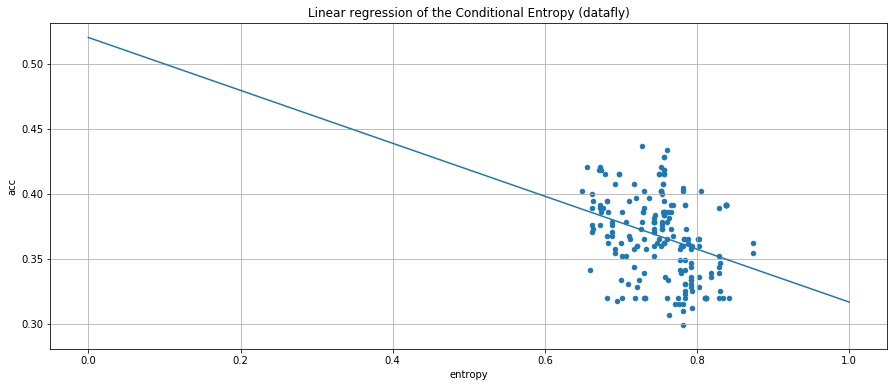

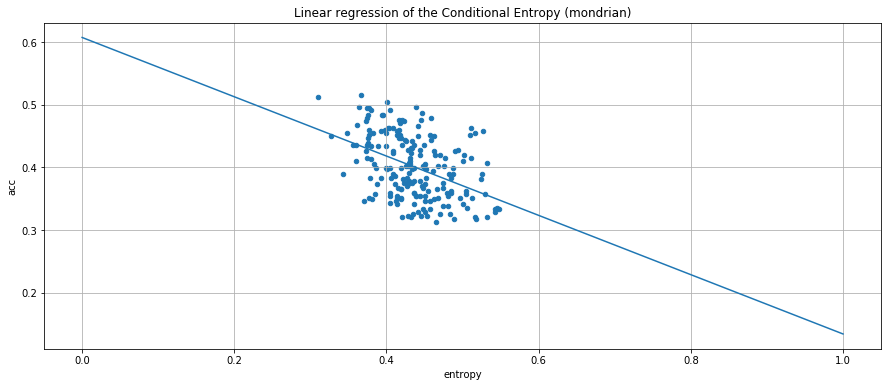

In [13]:
fit_and_graph("entropy", dataf)
print()
fit_and_graph("entropy", mondr)

### Classification Metric

Regression on datafly
p-value: 0.4680446296638004
R2 Score: 0.0026627099690480494
MSE: 0.002057571597168022
Coeffs: [-0.07609275]
Intercept: 0.4094812606692091

Regression on mondrian
p-value: 0.0030527028201702854
R2 Score: 0.04346065454808545
MSE: 0.0019816121346582782
Coeffs: [-0.43399003]
Intercept: 0.5878286779014481


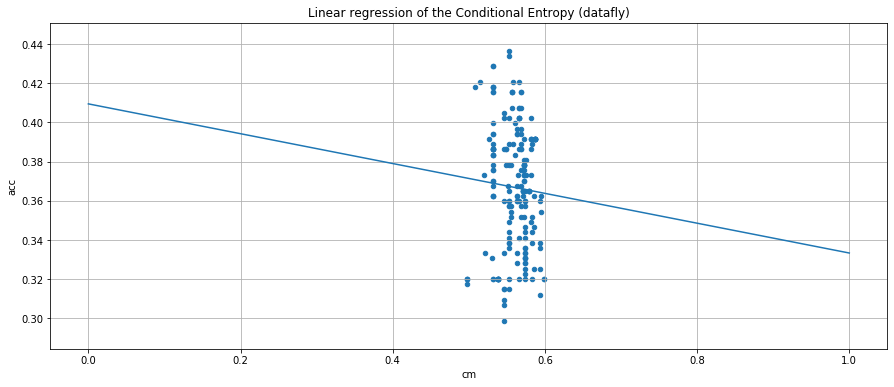

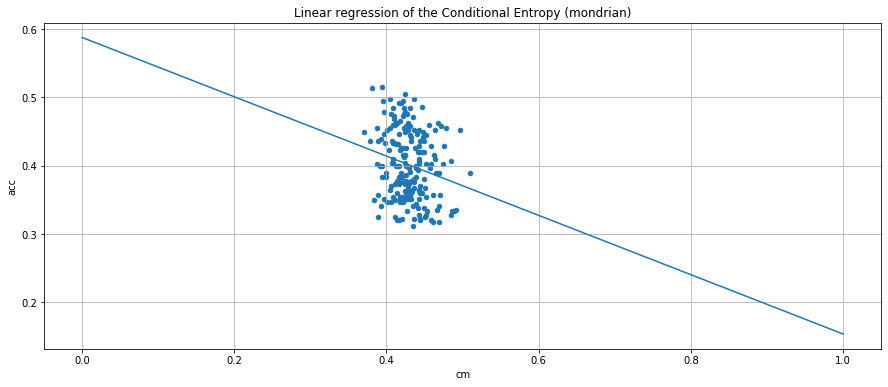

In [14]:
fit_and_graph("cm", dataf)
print()
fit_and_graph("cm", mondr)

### DM

Regression on datafly
p-value: 0.5203437551481386
R2 Score: 0.0020900174103174463
MSE: 0.0027427446109916775
Coeffs: [-0.02129255]
Intercept: 0.37507206682639654

Regression on mondrian
p-value: 0.13919538444360618
R2 Score: 0.011011429394109151
MSE: 0.00271755728988441
Coeffs: [0.17210977]
Intercept: 0.2592768954301369


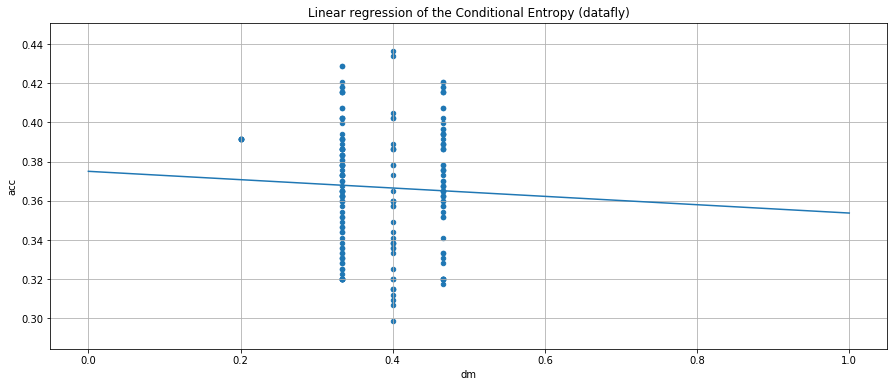

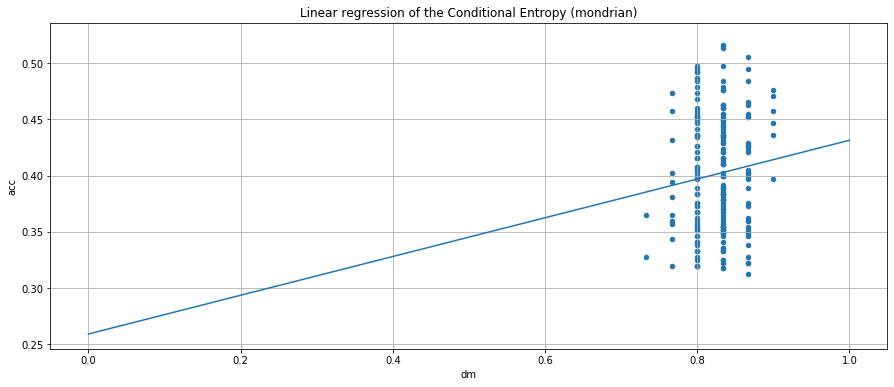

In [15]:
fit_and_graph("dm", dataf)
print()
fit_and_graph("dm", mondr)

### Precision


Regression on datafly
p-value: 0.0003768597740381854
R2 Score: 0.062010948786627385
MSE: 0.002438966771348529
Coeffs: [0.56811021]
Intercept: -0.08346730694605448

Regression on mondrian
p-value: 0.001104593281083908
R2 Score: 0.052463933705964916
MSE: 0.0024320207342117188
Coeffs: [0.54607896]
Intercept: -0.027089868606948175


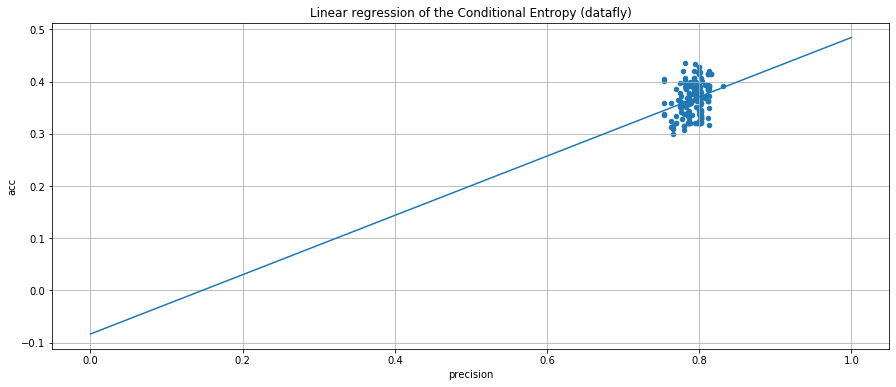

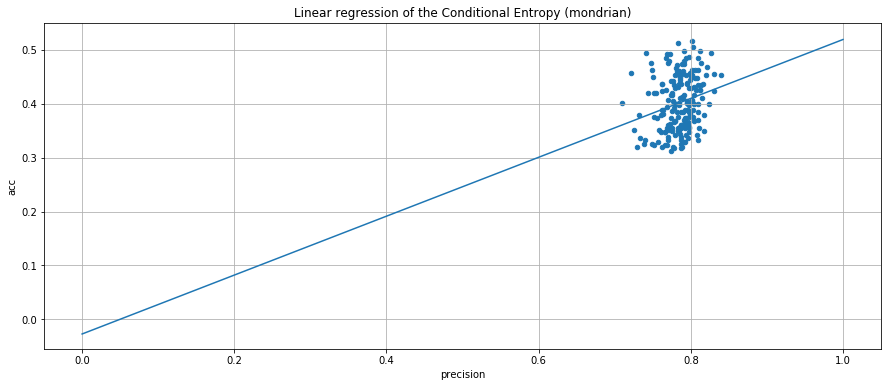

In [16]:
fit_and_graph("precision", dataf)
print()
fit_and_graph("precision", mondr)

### Discernability

Regression on datafly
p-value: 1.7138222723223753e-10
R2 Score: 0.18650266319448994
MSE: 0.0016493907027528944
Coeffs: [-0.16431526]
Intercept: 0.4067606291147816

Regression on mondrian
p-value: 0.0006265433939523714
R2 Score: 0.05749716795897297
MSE: 0.0072618946020004075
Coeffs: [-0.65210445]
Intercept: 0.4265071915284072


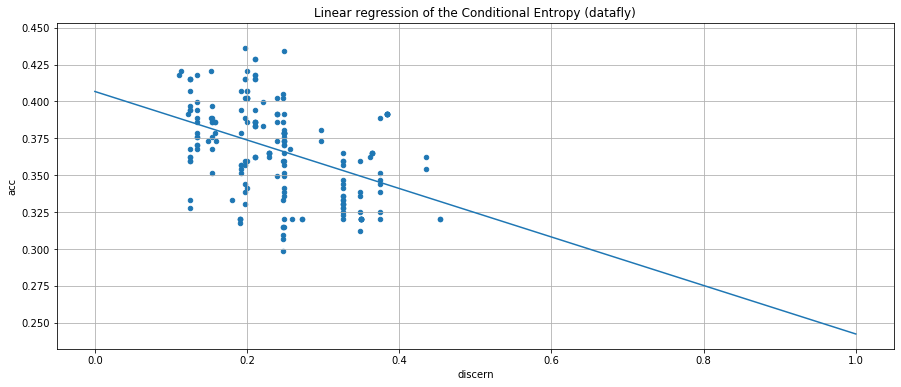

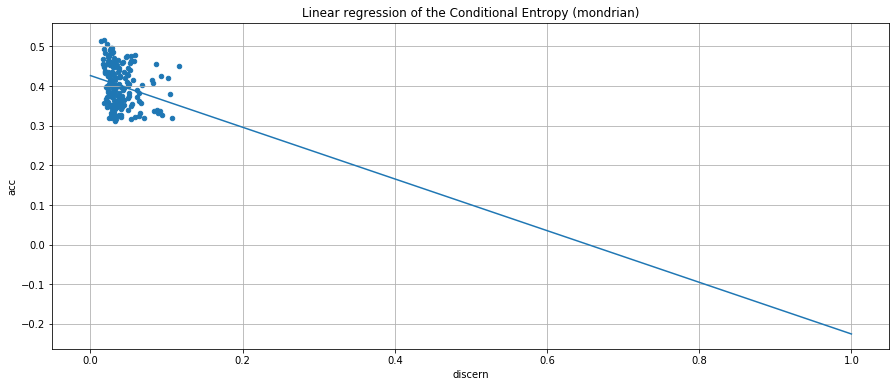

In [17]:
fit_and_graph("discern", dataf)
print()
fit_and_graph("discern", mondr)

### Information Loss Metric

Regression on datafly
p-value: 1.7490185722434234e-07
R2 Score: 0.12906214399107574
MSE: 0.001728638819782293
Coeffs: [-0.71690962]
Intercept: 0.5026533147858231

Regression on mondrian
p-value: 2.87129651747912e-05
R2 Score: 0.08479905112703323
MSE: 0.0016393969782152922
Coeffs: [-1.01422111]
Intercept: 0.566408597326284


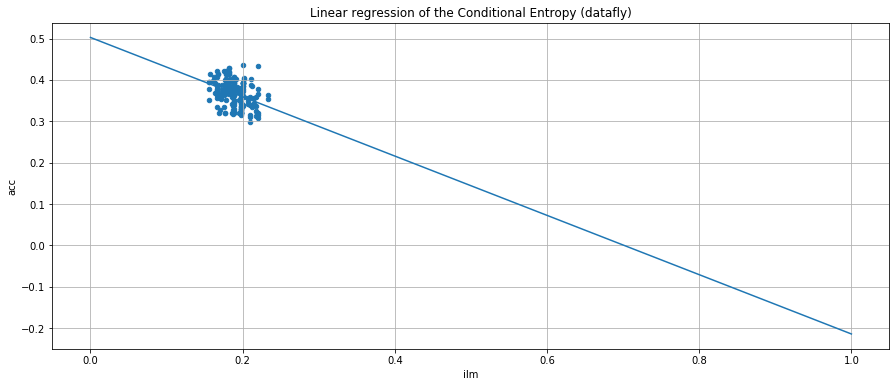

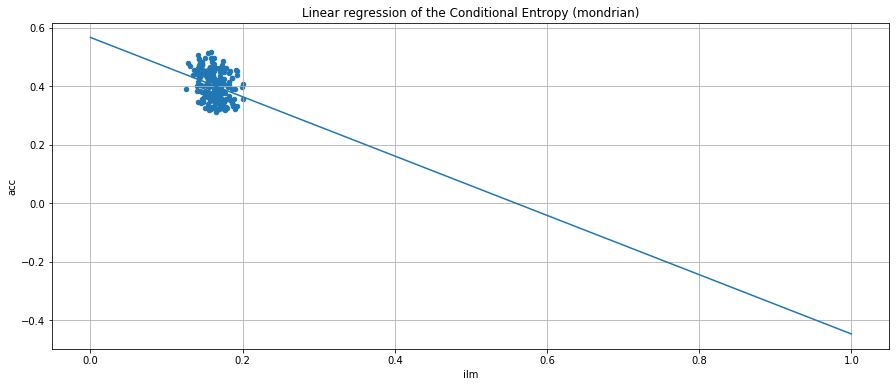

In [18]:
fit_and_graph("ilm", dataf)
print()
fit_and_graph("ilm", mondr)

### Multiple Metrics

In [19]:
metrics = ["entropy", "cm", "dm", "precision", "discern", "ilm"]

res = []
for i in range(1,6):
    
    for comb in itertools.combinations(metrics, i):
        
        ms = list(comb)
        for alg in [dataf, mondr]:
            name = alg["algo"].iloc[0] 
            reg, score = regress(ms, alg)
            err = mse(reg, ms)
            p_val = scipy.stats.pearsonr(alg[ms[0]], alg['acc'])[1] if i == 1 else None
            res.append((str(ms), name, p_val, score, err))

            
df = pd.DataFrame(res, columns=["metrics", "algo", "p_value", "R2_score", "MSE_error"])
df = df.set_index(["metrics", "algo"])
df.head(20)

p_value  R2_score  MSE_error
metrics                  algo                                       
['entropy']              datafly   5.345932e-06  0.099544   0.002017
                         mondrian  1.863530e-10  0.185828   0.008293
['cm']                   datafly   4.680446e-01  0.002663   0.002058
                         mondrian  3.052703e-03  0.043461   0.001982
['dm']                   datafly   5.203438e-01  0.002090   0.002743
                         mondrian  1.391954e-01  0.011011   0.002718
['precision']            datafly   3.768598e-04  0.062011   0.002439
                         mondrian  1.104593e-03  0.052464   0.002432
['discern']              datafly   1.713822e-10  0.186503   0.001649
                         mondrian  6.265434e-04  0.057497   0.007262
['ilm']                  datafly   1.749019e-07  0.129062   0.001729
                         mondrian  2.871297e-05  0.084799   0.001639
['entropy', 'cm']        datafly            NaN  0.115287   0.001705
                         mondrian           NaN  0.219033   0.008175
['entropy', 'dm']        datafly            NaN  0.303864   0.001461
                         mondrian           NaN  0.186562   0.010641
['entropy', 'precision'] datafly            NaN  0.147738   0.001753
                         mondrian           NaN  0.190366   0.007014
['entropy', 'discern']   datafly            NaN  0.209698   0.002935
                         mondrian           NaN  0.196034   0.004365